In [12]:
import datajoint as dj
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import statsmodels.api as sm
import behav_viz.utils.plot_utils as pu
import utils as u
dj.blob.use_32bit_dims = True  # not using blob columns
sns.set_context("talk")
OVERWRITE_DATA = False

[2025-06-11 13:59:49,380][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2025-06-11 13:59:50,842][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


# 1. Load & Clean


In [2]:
bdata = dj.create_virtual_module("bdata", "bdata")
key = {"protocol": "PWM"}
pwm_df = pd.DataFrame(
    (bdata.Sessions & key & 'sessiondate > "2020-05-01"').fetch(as_dict=True)
)

In [3]:
## 1.0 Renaming columns

pwm_df.rename(columns={"ratname": "animal_id", "sessiondate": "date"}, inplace=True)
pwm_df["percent_violations"] = pwm_df["percent_violations"] * 100


## 1.1 Dropping

- Josh animals since these are Bpod testers
- Any PWM2 animals since they had a different protocol
- sessions with < 1 trial or > 99 % violation rate
- Animals with less than 50 sessions


In [4]:
pwm2_animals = ["Y005", "Y006", "Y007", "Y008"]  # PWM2 animals



pwm_df = pwm_df.query(
    "experimenter != 'Josh' and "
    "animal_id not in @pwm2_animals and "
    "n_done_trials > 1 and "
    "percent_violations < 99"
).copy()

valid_animals = (
    pwm_df.groupby("animal_id")
    .filter(lambda x: len(x) > 50)["animal_id"]
    .unique()
)
pwm_df = pwm_df.query("animal_id in @valid_animals").copy()



[Text(0.5, 1.0, 'Number of sessions per animal'),
 Text(0.5, 0, 'Animal'),
 Text(0, 0.5, 'Number of sessions')]

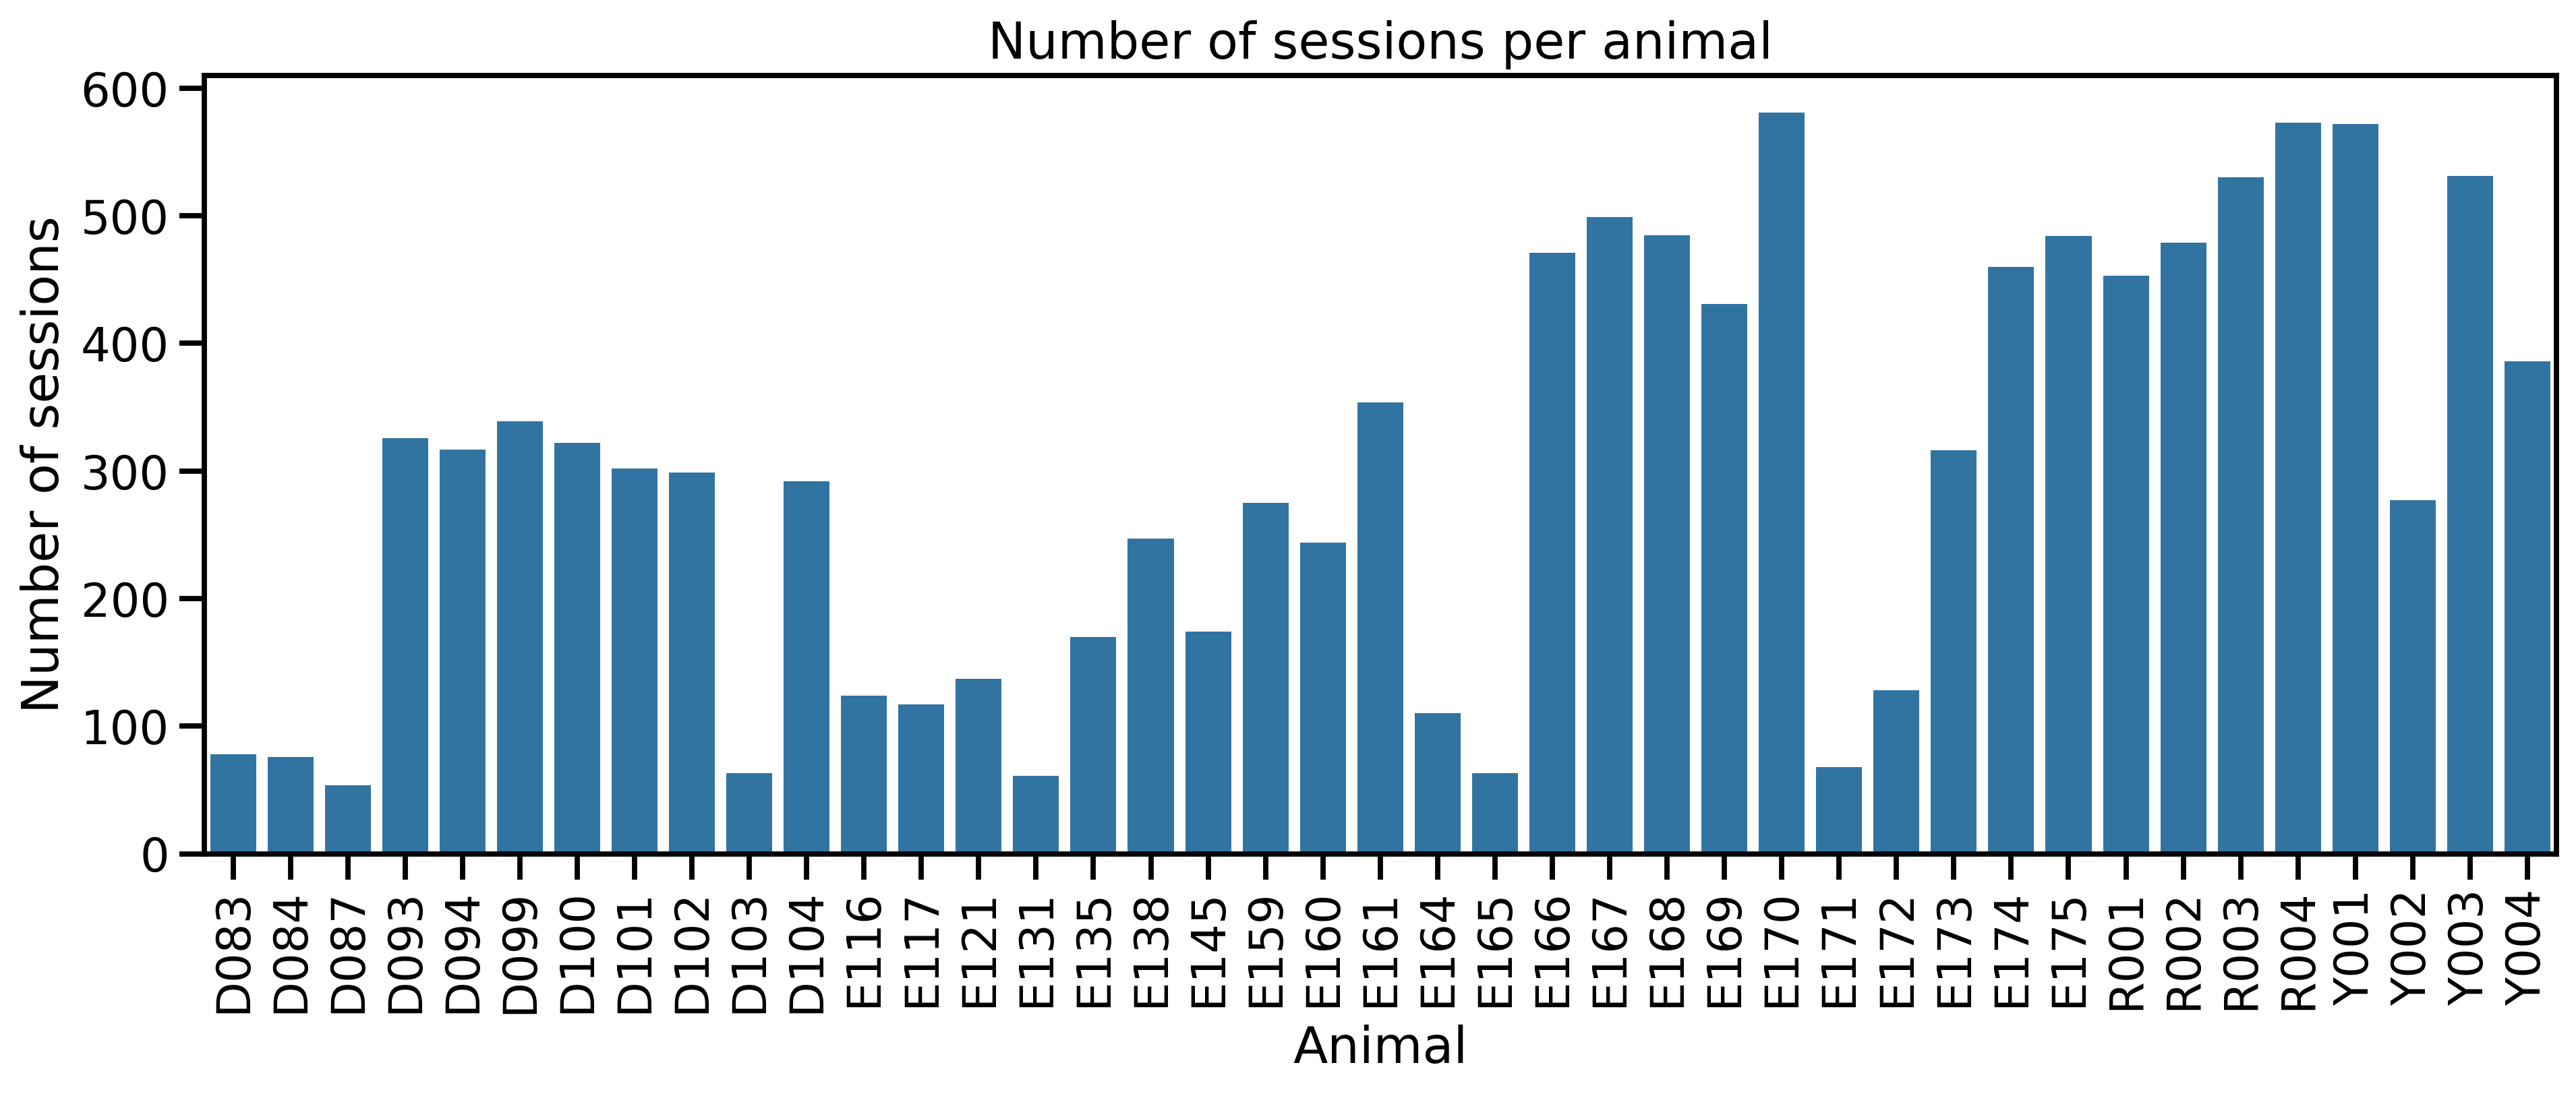

In [5]:
fig, ax = pu.make_fig((15, 5))

n_sessions_df = pwm_df.groupby("animal_id").date.count().reset_index()
n_sessions_df.rename(columns={"date": "n_sessions"}, inplace=True)

sns.barplot(
    n_sessions_df.query("animal_id in @valid_animals"),
    x="animal_id",
    y="n_sessions",
)

ax.tick_params(axis="x", rotation=90)
ax.set(
    title="Number of sessions per animal",
    xlabel="Animal",
    ylabel="Number of sessions",
)

## 1.2 Label Stages Given Comment String

We can infer the session stages by reading from the comments string. We will drop any sessions with unknown comments and we will drop the spoke stages since we are only interest in center poke stages onward (although it would be interesting to analyze these eventually)


In [6]:
pwm_df.comments.tail()

14908    11 never, t= 157, v= 0.18, h= 0.66\ndelta=5.0\...
14909    11 never, t= 185, v= 0.11, h= 0.68\ndelta=5.0\...
14910    11 never, t= 124, v= 0.13, h= 0.65\ndelta=5.0\...
14911    11 never, t= 282, v= 0.20, h= 0.67\ndelta=5.0\...
14912    11 never, t= 172, v= 0.17, h= 0.78\ndelta=5.0\...
Name: comments, dtype: object

In [7]:
def determine_stage(row):
    if "comments" not in row:
        return "unknown"

    comment = row["comments"]
    if isinstance(comment, str):
        if "grow" in comment.lower():
            return "gnp", 2
        elif "always" in comment.lower():
            return "always", 3
        elif "delayed" in comment.lower():
            return "delayed", 4
        elif "never" in comment.lower() or "psych" in comment.lower():
            return "never", 5
        elif "learning" in comment.lower():
            return "spoke", 1
        elif "error" in comment.lower() or "unable" in comment.lower():
            return "error", np.nan
    return "unknown", 0


pwm_df[["stage_name", "stage"]] = pwm_df.apply(
    determine_stage, axis=1, result_type="expand"
)

drop_stages = ["error", "unknown", "spoke"]
pwm_df = pwm_df.query("stage_name not in @drop_stages").copy()

pwm_df[["stage_name", "stage"]].value_counts()


stage_name  stage
never       5.0      5685
gnp         2.0      2895
delayed     4.0      2760
always      3.0       569
Name: count, dtype: int64

## 1.3 Determine if trained

We will use a similar method to that in the Akrami PWM dataset where there is a rolling hit rate that reaches 72.5% and stays above


In [8]:
pwm_df = u.compute_days_relative_to_stage(pwm_df, stage=2)
pwm_df = pwm_df.query("days_relative_to_stage_2 >= 0").copy() # remove sessions before stage 2 for animals that got reset post covid

In [9]:
def compute_rolling_mean(df, column, window_size):
    """
    Function to compute the rolling mean of a column for each ratname
    across sessions
    """
    grouped_over_sessions = (
        df.groupby(["animal_id", "date", "days_relative_to_stage_2"])[column].mean().reset_index()
    )
    rolling_mean = (
        grouped_over_sessions.groupby("animal_id")
        .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())
        .reset_index()
    )

    rolling_mean.rename(columns={column: f"rolling_mean_{column}"}, inplace=True)
    rolling_mean["window_size"] = window_size

    return pd.merge(
        grouped_over_sessions,
        rolling_mean.drop(columns=["animal_id"]),  # already in grouped df
        left_index=True,
        right_on="level_1",  # index of grouped df
        how="left",
    ).drop(columns=["level_1"])

In [10]:
hit_rolling_mean = compute_rolling_mean(
    pwm_df.query("stage_name == 'never'"), "total_correct", window_size=21
)

hit_rolling_mean.head()

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_43835/3915518081.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())


,animal_id,date,days_relative_to_stage_2,total_correct,rolling_mean_total_correct,window_size
0,D093,2022-02-05,177.0,0.68,0.680000,21
1,D093,2022-02-06,178.0,0.50,0.590000,21
2,D093,2022-02-07,179.0,0.67,0.616667,21
3,D093,2022-02-08,180.0,0.64,0.622500,21
4,D093,2022-02-10,181.0,0.51,0.600000,21


/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_43835/3915518081.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[column].rolling(window=window_size, min_periods=1).mean())


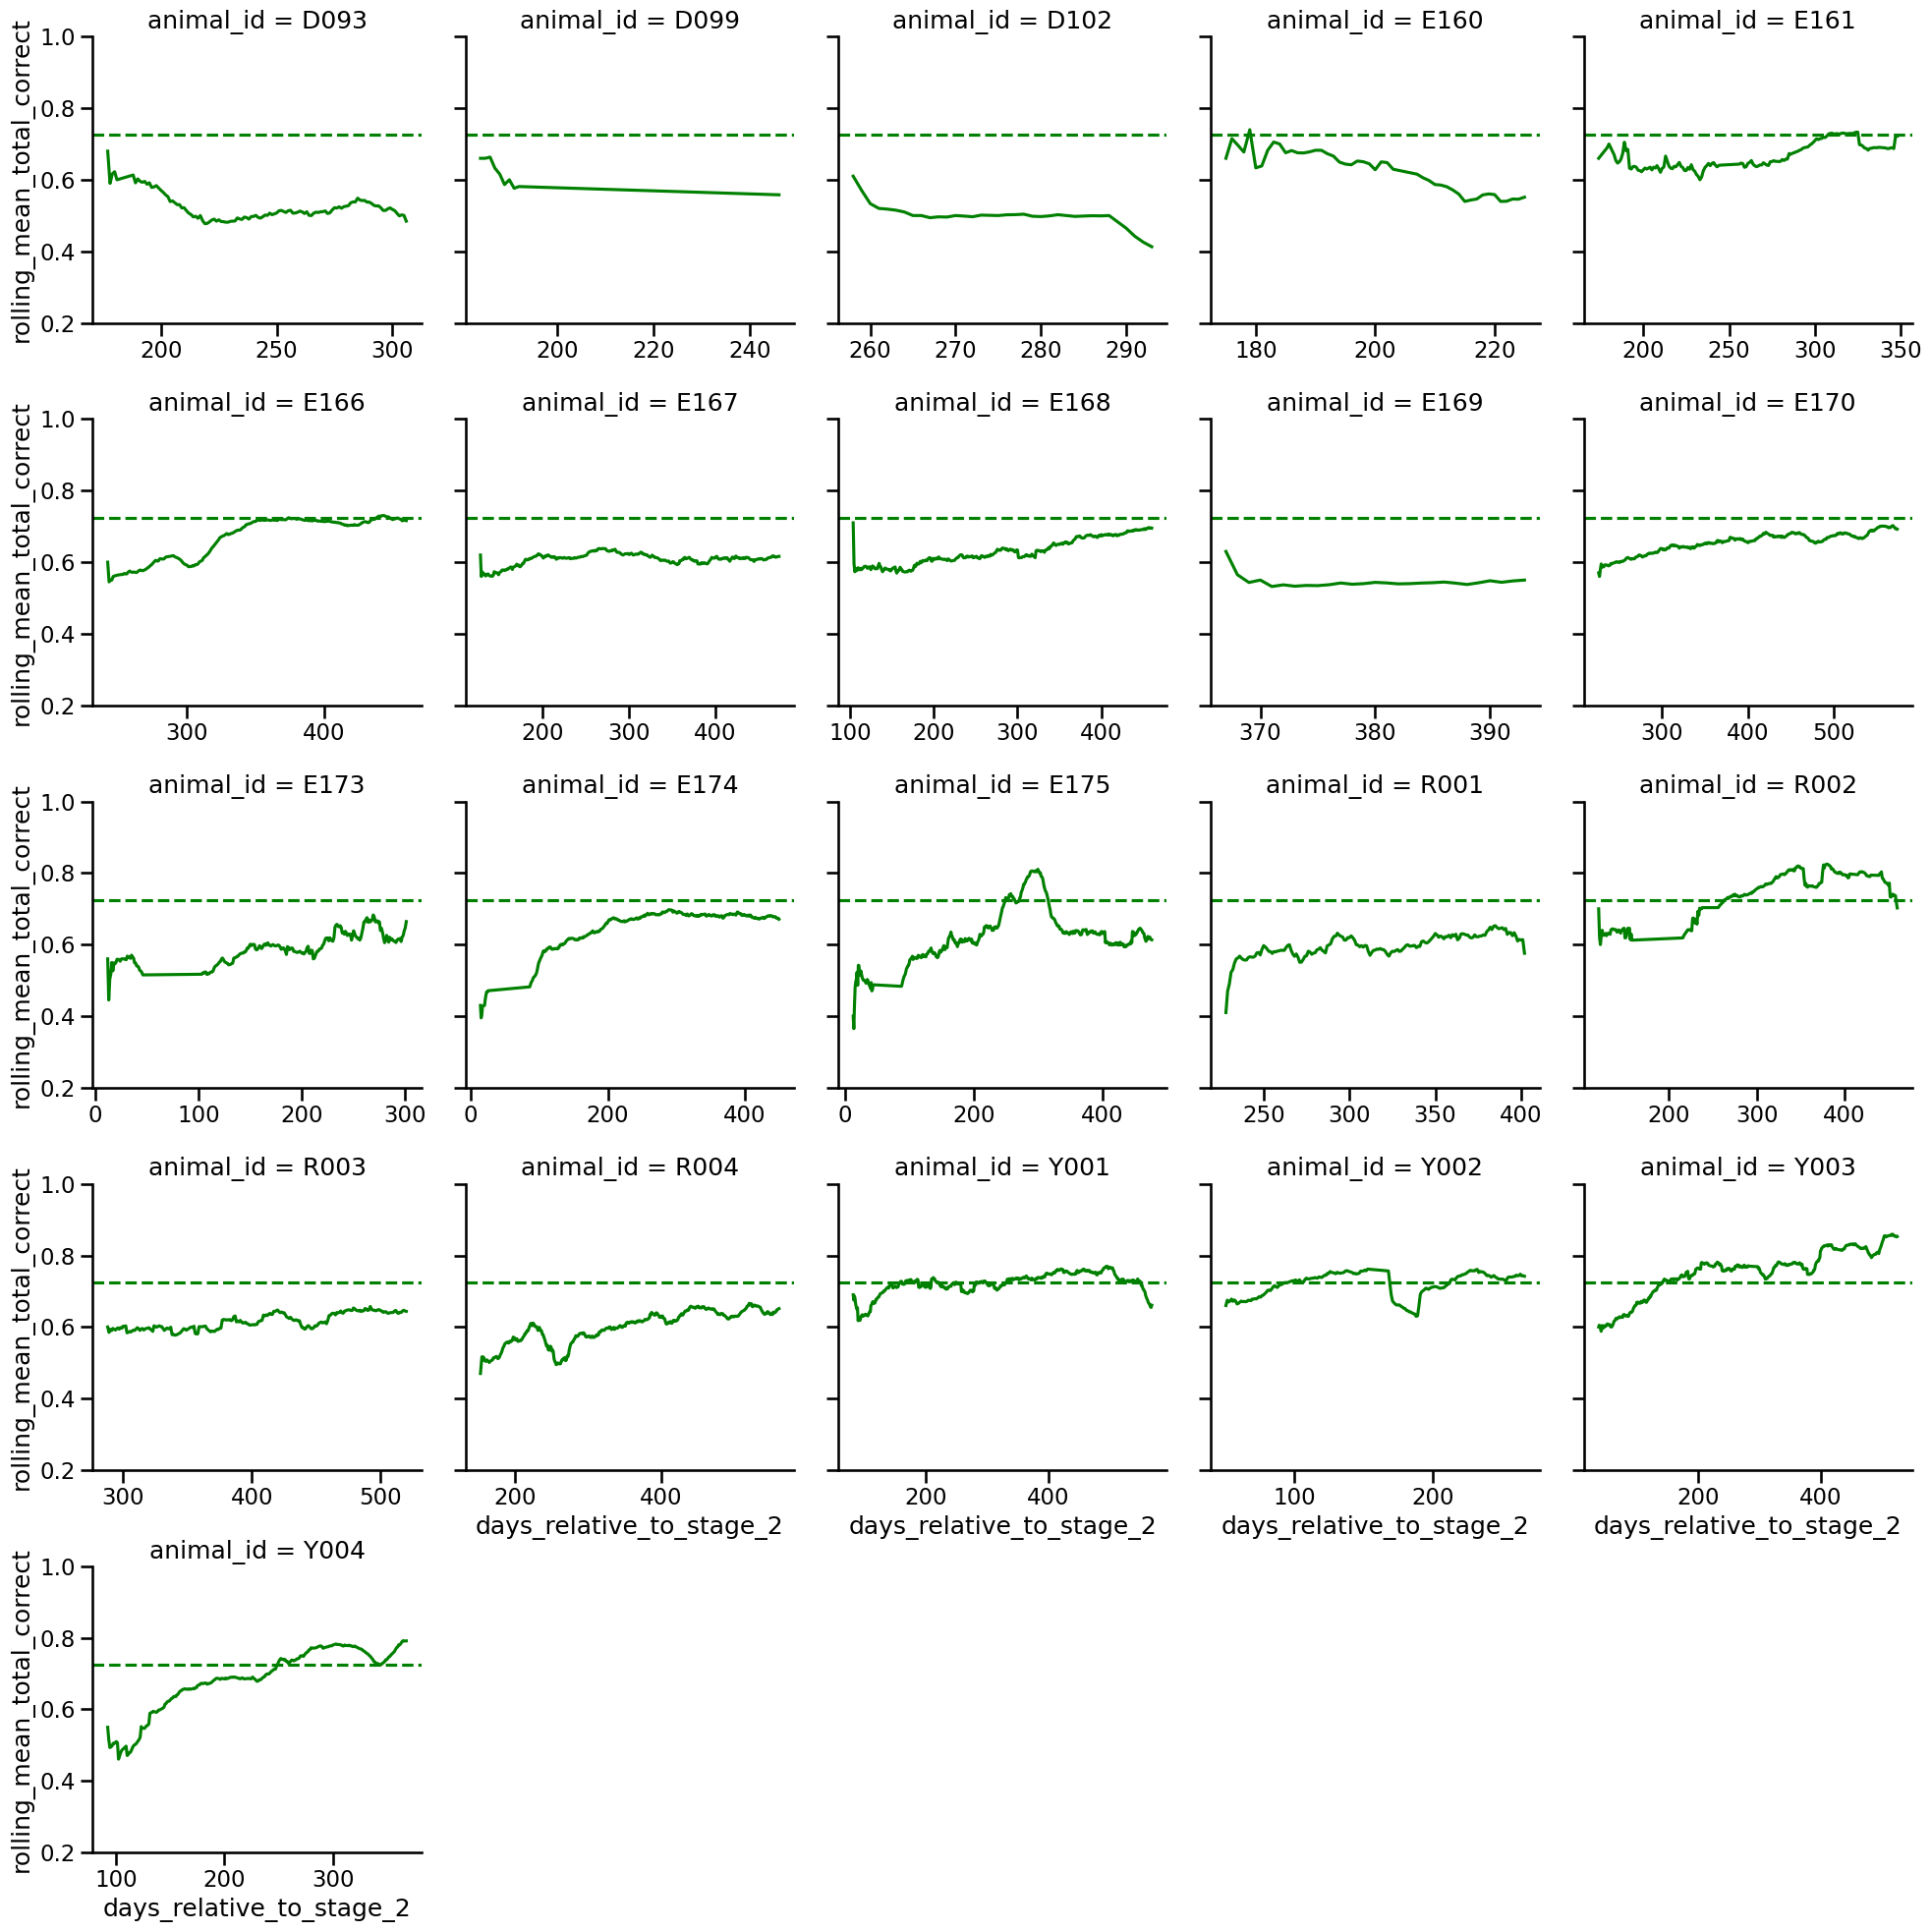

In [11]:
hit_rolling_mean = compute_rolling_mean(
    pwm_df.query("stage_name == 'never'"), "total_correct", window_size=21
)

g = sns.FacetGrid(
    data=hit_rolling_mean, col="animal_id", col_wrap=5, height=4, ylim=(0.2, None), sharex=False
)
g.map(sns.lineplot, "days_relative_to_stage_2", "rolling_mean_total_correct", color="green")
g.map(plt.axhline, y=0.725, color="green", linestyle="--")

In [12]:
trained_animals = [
    "E175",
    "R002",
    "Y001",
    "Y002",
    "Y003",
    "Y004",
]  # just doing this by eye- not going to over-complicate things

pwm_df["trained"] = pwm_df.animal_id.isin(trained_animals)

animals_in_hit_rolling_mean = hit_rolling_mean["animal_id"].unique()
pwm_df["sound_rule_never"] = pwm_df.animal_id.isin(animals_in_hit_rolling_mean)



## 1.4 Stage Progression

We only want to include animals that had a standard stage progression of GNP - always - delayed - never


### 1.4.1 Strict pwm_df - only animals that made it through all stages


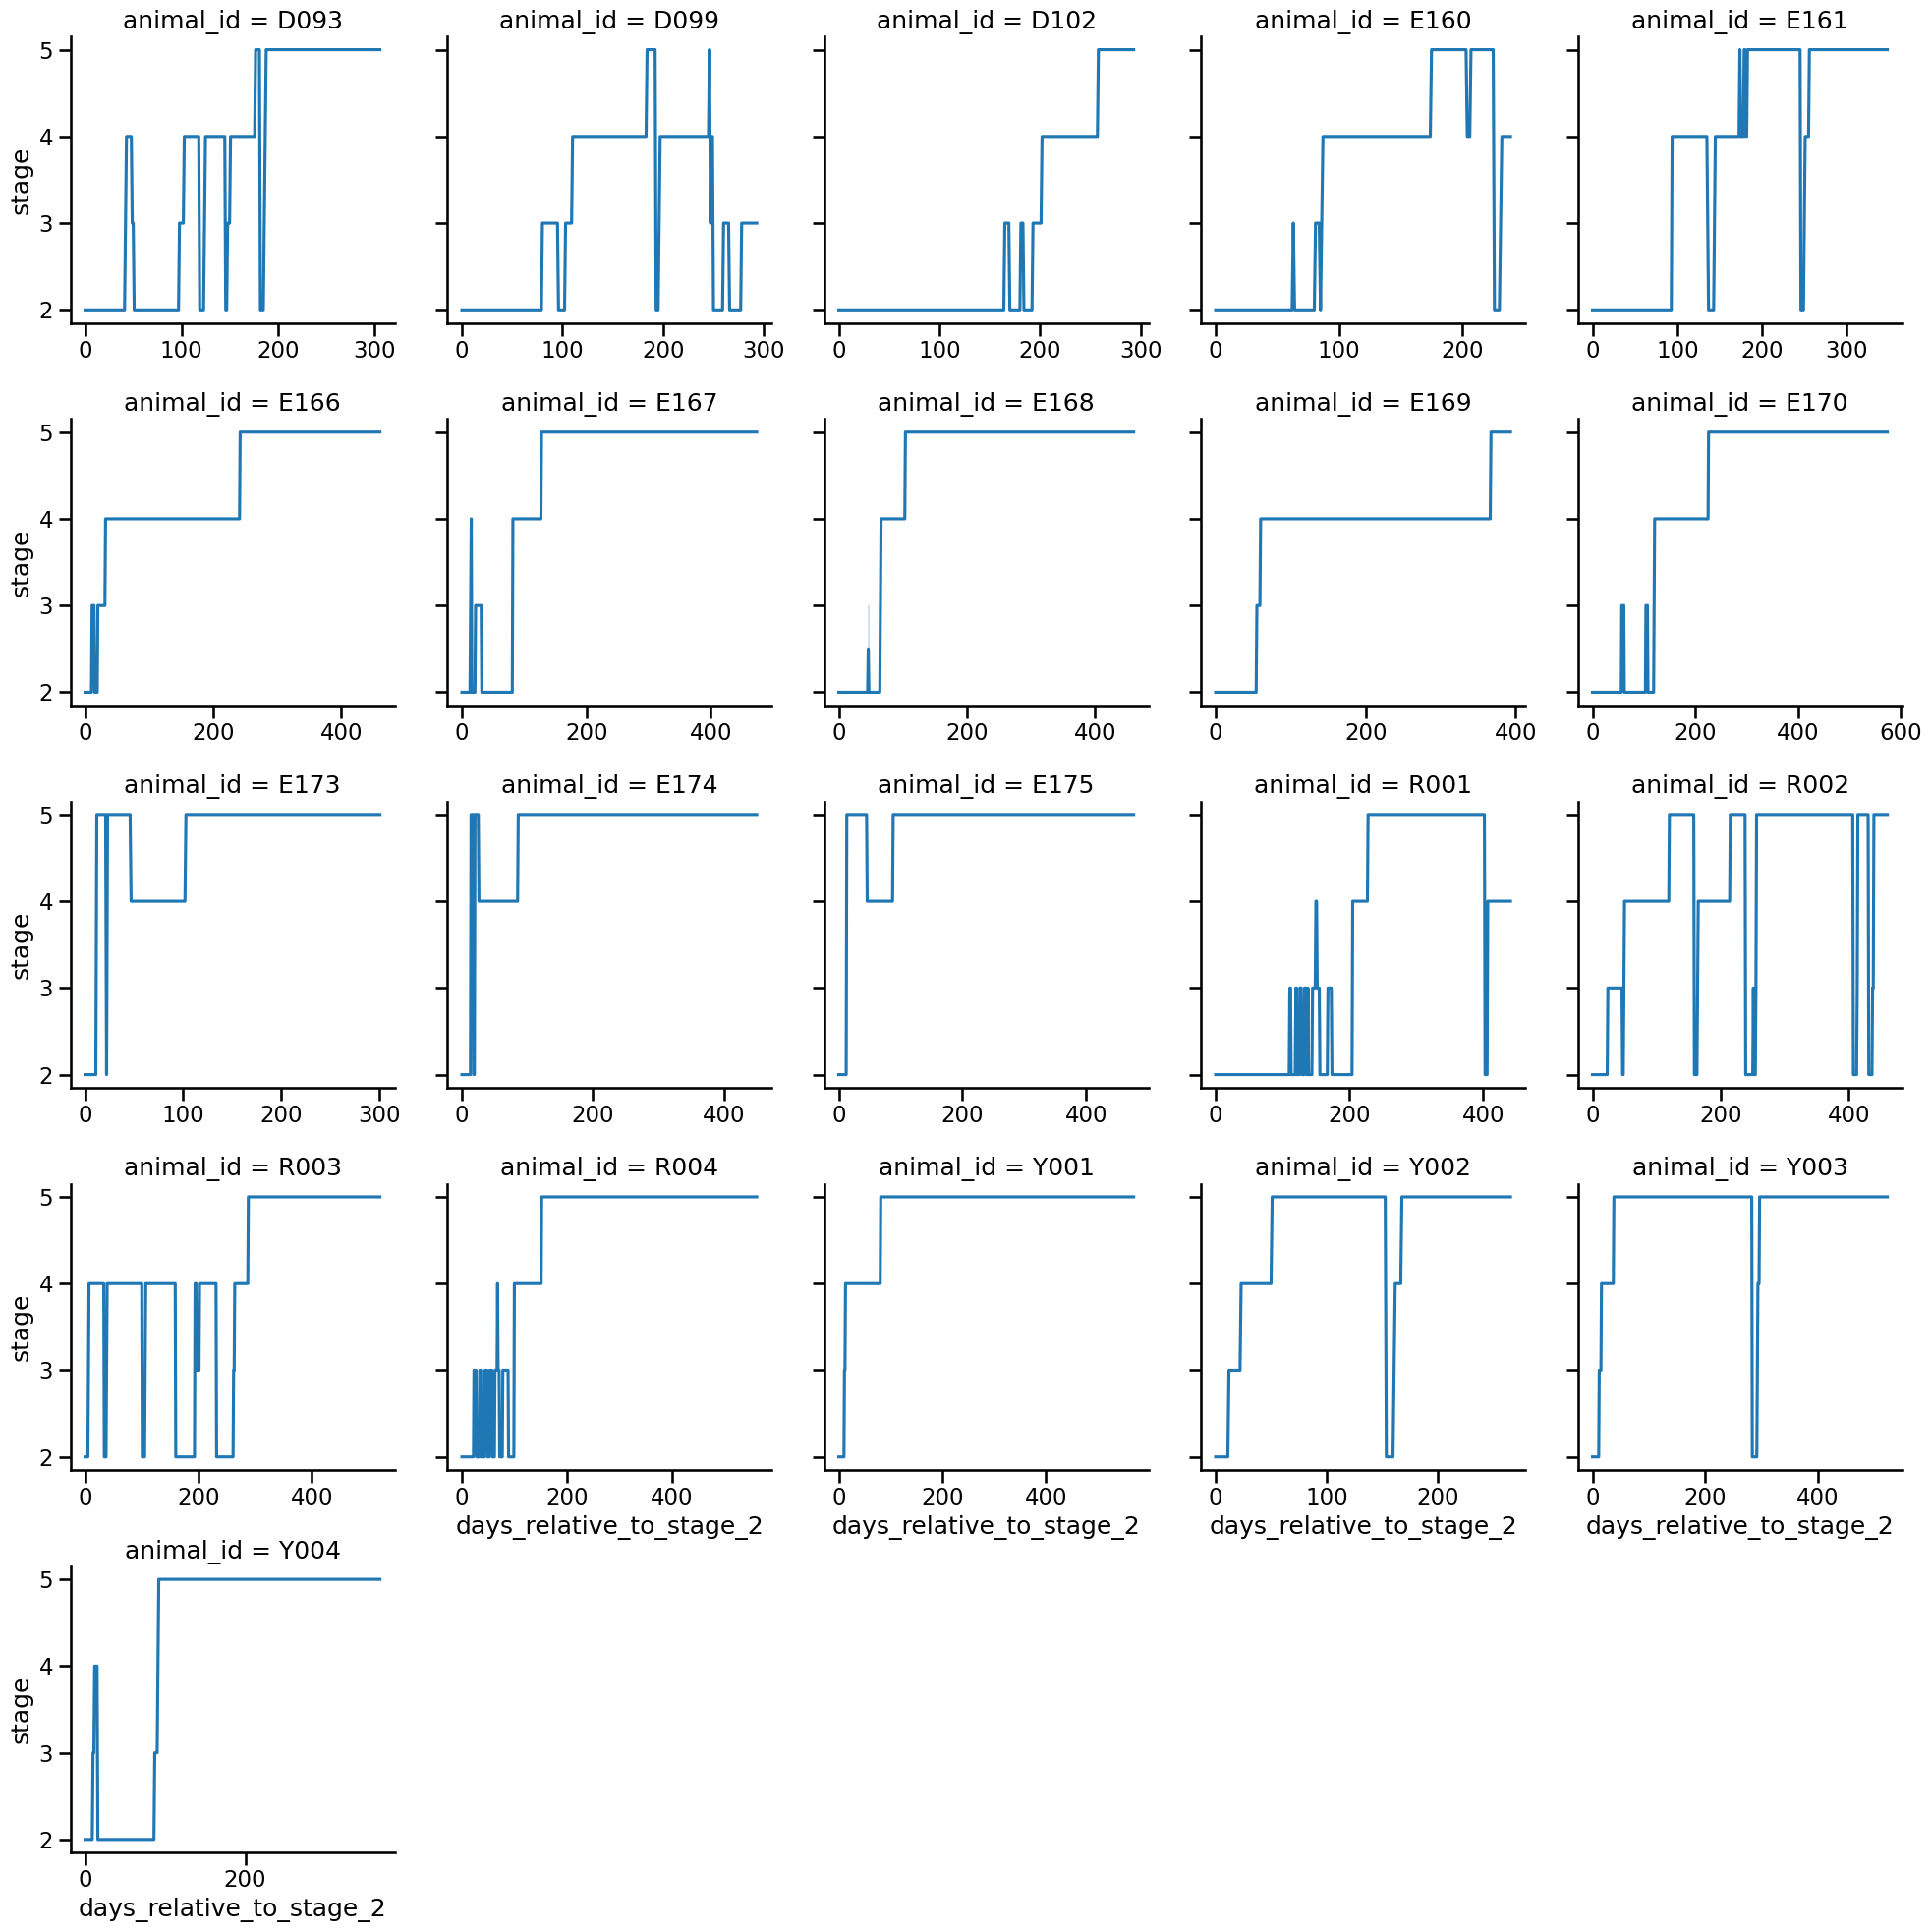

In [13]:
# Make sure data is sorted within each animal_id and stage group
plot_df = pwm_df.query("sound_rule_never").sort_values(by=["animal_id", "stage", "days_relative_to_stage_2"])

# Create the FacetGrid
g = sns.FacetGrid(
    data=plot_df,
    col="animal_id",
    col_wrap=5,
    height=4,
    sharey=True,  # Optional: make y-axis comparable across facets
    sharex=False
)

# Use lineplot with 'sort=False' only if your data is already sorted
g.map_dataframe(
    sns.lineplot,
    x="days_relative_to_stage_2",
    y="stage",
    legend=False
)


plt.tight_layout()
plt.show()

### 1.4.2 Not strict pwm_df - all animals that started stage 2


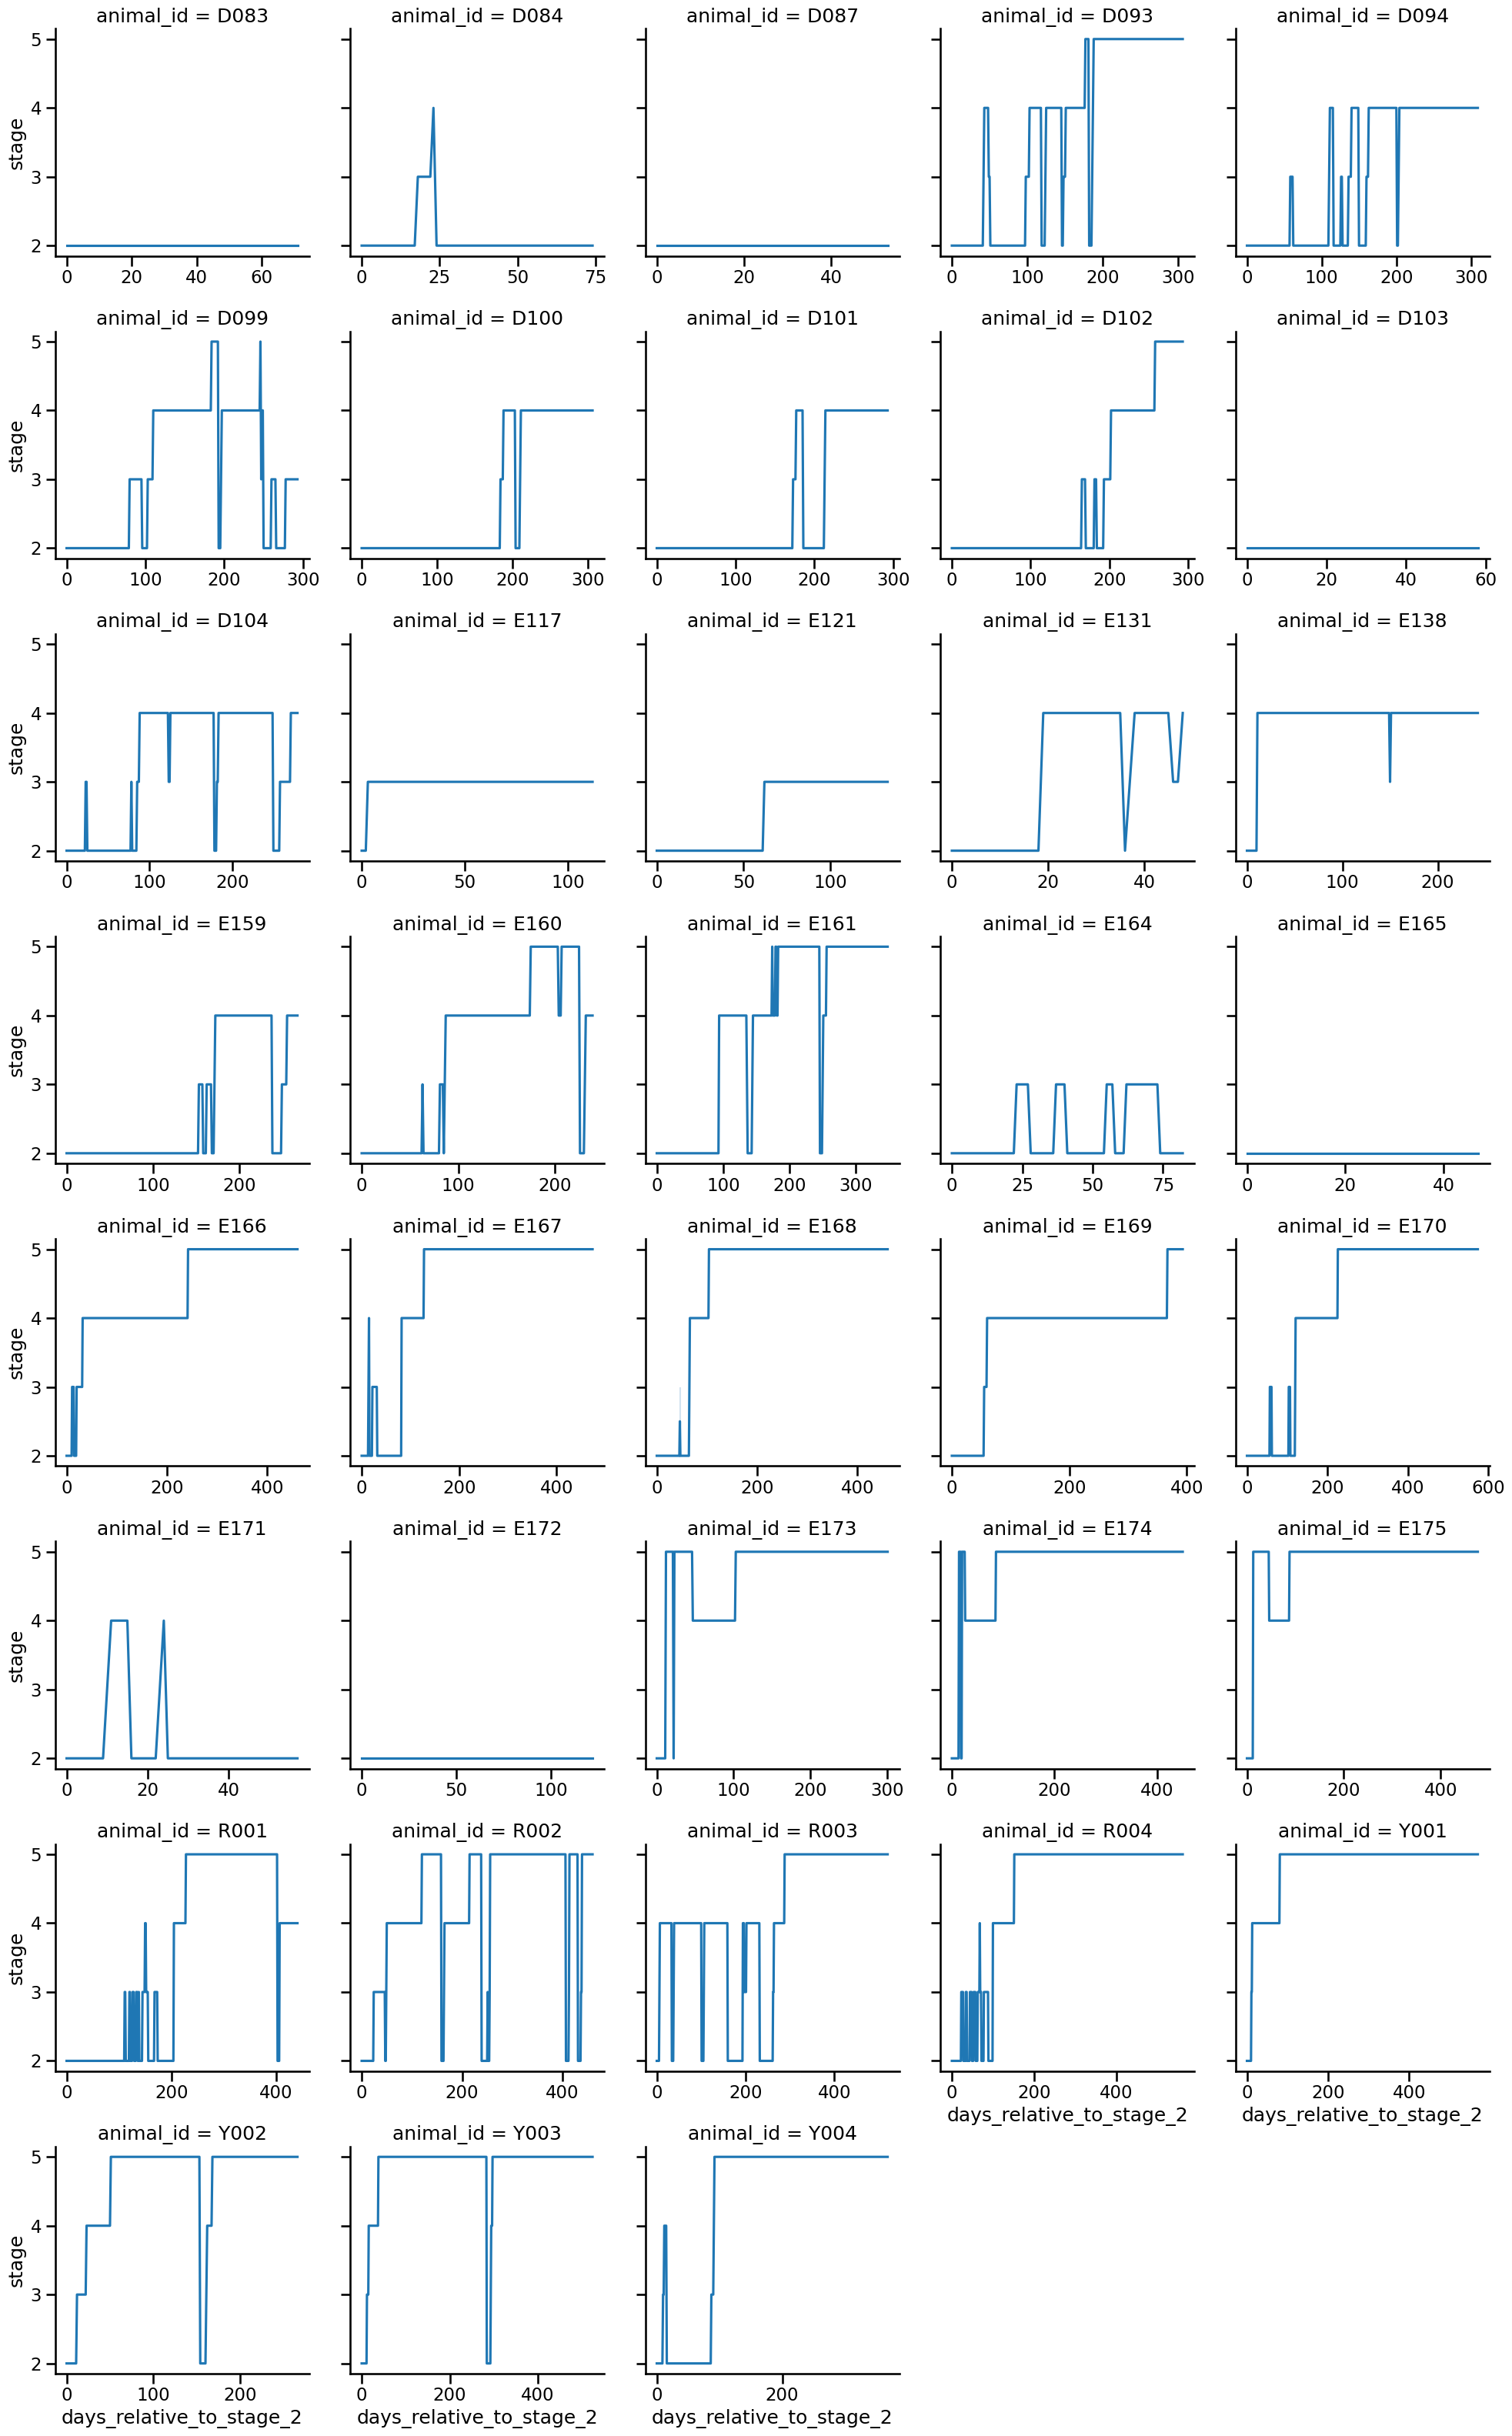

In [14]:
# Make sure data is sorted within each animal_id and stage group
plot_df = pwm_df.sort_values(by=["animal_id", "stage", "days_relative_to_stage_2"])

# Create the FacetGrid
g = sns.FacetGrid(
    data=plot_df,
    col="animal_id",
    col_wrap=5,
    height=4,
    sharey=True,  # Optional: make y-axis comparable across facets
    sharex=False
)

# Use lineplot with 'sort=False' only if your data is already sorted
g.map_dataframe(
    sns.lineplot,
    x="days_relative_to_stage_2",
    y="stage",
    legend=False
)


plt.tight_layout()
plt.show()

## 1.5 Yield


In [15]:
def compute_stage_counts(df, trained_animals):
    stage_counts = (
        df.query("stage != 3").groupby("stage")["animal_id"]
        .nunique()
        .sort_index()
        .reset_index()
        .rename(columns={"animal_id": "n_animals"})
    )

    # Add readable stage names
    stage_counts["stage_name"] = stage_counts["stage"].map({
        2.0: "Fixation",
        4.0: "Sound Rule Delayed Rew",
        5.0: "Sound Rule Never",
    })

    # Map to completion markers
    stage_counts["completed"] = stage_counts["stage"].map({
        2.0: "NA",
        4.0: "Fixation",
        5.0: "Sound Rule On",
    })

    # Calculate yield early to avoid NaNs after concat
    stage_counts["yield"] = (
        (stage_counts["n_animals"] / stage_counts["n_animals"].max()) * 100
    ).round(0)

    # Create final summary row as a DataFrame
    summary_row = pd.DataFrame([{
        "stage": 6,
        "n_animals": len(trained_animals),
        "stage_name": "Sound Rule Never",
        "completed": "Trained",
        "yield": round((len(trained_animals) / stage_counts["n_animals"].max()) * 100)
    }])

    # Append to the main DataFrame
    stage_counts = pd.concat([stage_counts, summary_row], ignore_index=True)

    return stage_counts

In [16]:
compute_stage_counts(pwm_df, trained_animals) # want this df but only animals that completed stage 2- which is less strict than strict_pwm_df

,stage,n_animals,stage_name,completed,yield
0,2.0,38,Fixation,NA,100.0
1,4.0,30,Sound Rule Delayed Rew,Fixation,79.0
2,5.0,21,Sound Rule Never,Sound Rule On,55.0
3,6.0,6,Sound Rule Never,Trained,16.0


In [17]:
# First identify which animals have reached stage >= 3
exposed_animals = pwm_df.loc[pwm_df["stage"] >= 4, "animal_id"].unique()

# Assign True/False based on whether each row's animal_id is in that list
pwm_df["sound_rule_exposed"] = pwm_df["animal_id"].isin(exposed_animals)

In [18]:
stage_yeild_df = compute_stage_counts(pwm_df.query("sound_rule_exposed"), trained_animals)
stage_yeild_df 

,stage,n_animals,stage_name,completed,yield
0,2.0,30,Fixation,NA,100.0
1,4.0,30,Sound Rule Delayed Rew,Fixation,100.0
2,5.0,21,Sound Rule Never,Sound Rule On,70.0
3,6.0,6,Sound Rule Never,Trained,20.0


In [19]:
if OVERWRITE_DATA:
    pwm_df.drop(columns=["protocol_data"]).to_parquet("data/fpo_failed_pwm_df.parquet", index=False)


# 2. Visualizations


In [5]:
pwm_df = pd.read_parquet("data/fpo_failed_pwm_df.parquet")
pwm_df["training_label"] = pwm_df["trained"].apply(lambda x: "Learned" if x else "Failed")

In [5]:
LEARNED_PALETTE = ["mediumaquamarine", "firebrick"]
NO_HUE_COLOR = "lightgray"
LEARNED_ORDER = ["Learned", "Failed"]

## 2.1 Yield


In [13]:
# Create a new DataFrame for plotting

plot_data = pd.DataFrame({
    "status": ["Learned", "Failed"],
    "count": [6, 24]
}) # from table above


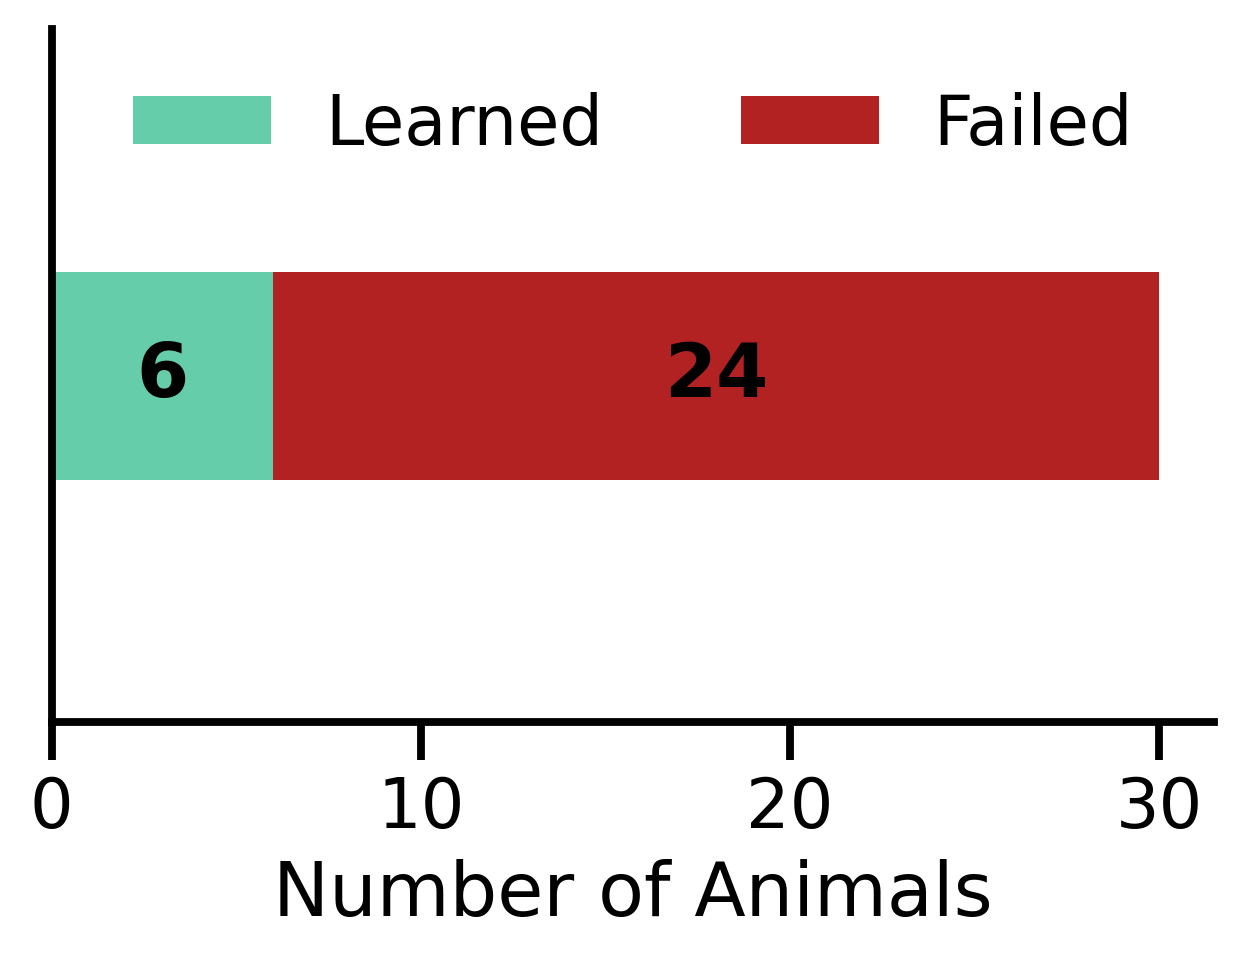

In [14]:

# Plot a horizontal stacked bar plot with thinner bars
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.barh(" ", plot_data["count"].sum(), color=LEARNED_PALETTE[0], label="Learned", height=0.6)
ax.barh(" ", plot_data.loc[1, "count"], color=LEARNED_PALETTE[1], label="Failed", left=plot_data.loc[0, "count"], height=0.6)

ax.set_xlabel("Number of Animals")
ax.set_ylim(-1, 1)
ax.legend(frameon=False, loc="upper center", ncol=2)
ax.set_yticks([])


ax.text(3, 0, "6", ha="center", va="center", fontweight="bold")
ax.text(18, 0, "24", ha="center", va="center", fontweight="bold")


sns.despine(ax=ax)


Text(15, 0, '30')

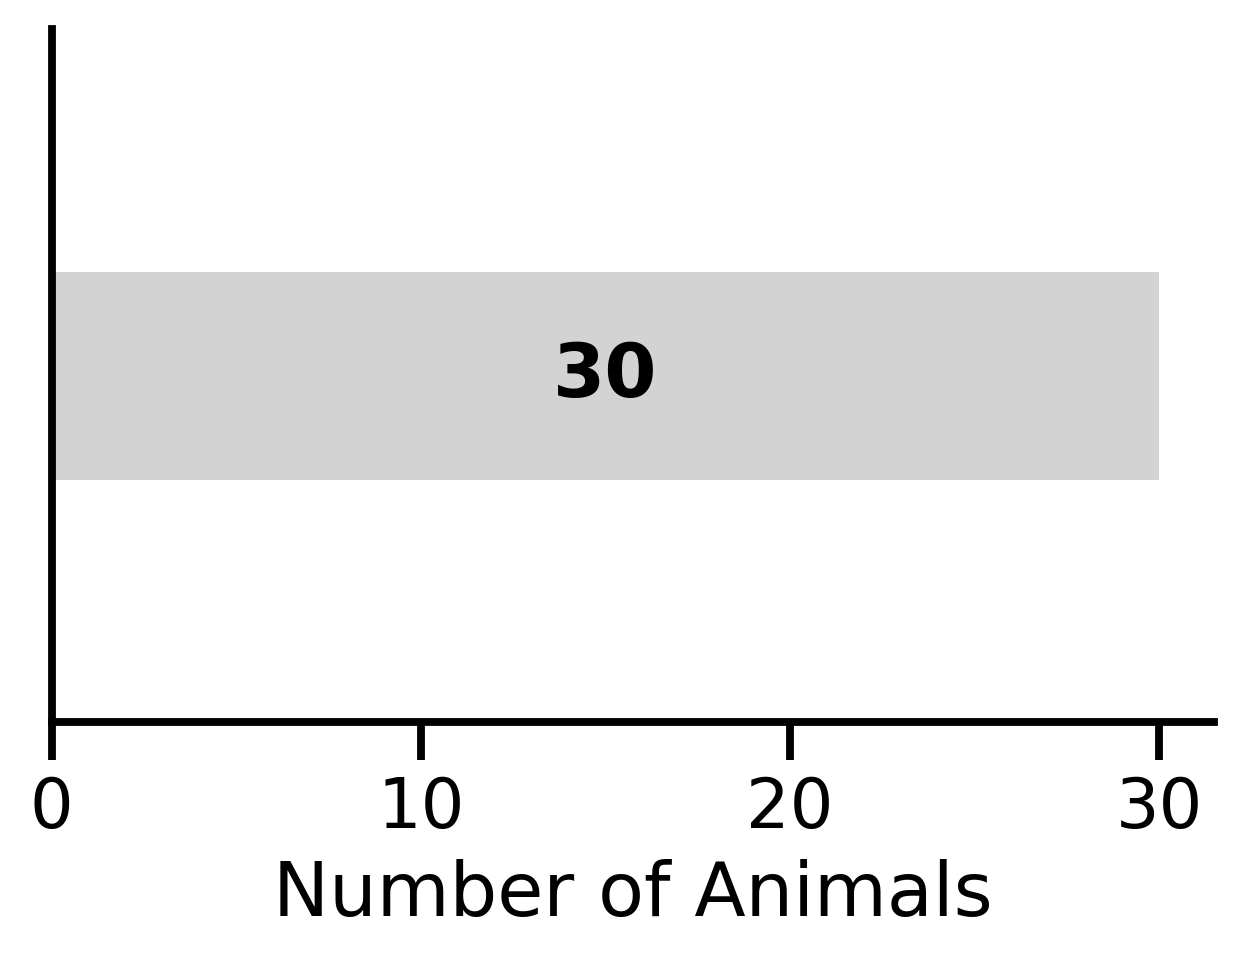

In [15]:
# Plot a horizontal stacked bar plot with thinner bars
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.barh(" ", 30, color=NO_HUE_COLOR, label="", height=0.6)

ax.set_xlabel("Number of Animals")
ax.set_ylim(-1, 1)
ax.set_yticks([])

sns.despine(ax=ax)

ax.text(15, 0, "30", ha="center", va="center", fontweight="bold")


## 2.2 Violation Rates


In [81]:
plot_df = pwm_df.query("sound_rule_exposed")

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_violations_hist(df, hue, palette, hue_order, ylim, label_ylim_pct, ax=None, title=None, **kwargs):
    """
    Plot a histogram of percent_violations with optional hue + median lines.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain 'percent_violations' and (if hue is not None) the hue column.
    hue : str or None
        Column name to split by; if None, no hue or median lines are drawn.
    palette : list or dict
        Colors to use for each hue level (ignored if hue is None).
    hue_order : list
        Order of hue levels to be used for sorting and plotting.
    ylim : tuple
        (ymin, ymax) for the y-axis.
    label_ylim_pct : float
        Where (as a fraction of ylim[1]) to place the median-line labels.
    ax : matplotlib.axes.Axes
        The axes on which to draw.
    title : str, optional
        If provided, sets ax.set_title(title).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4.5), dpi=300)
    # histogram
    sns.histplot(
        data=df,
        x="percent_violations",
        element="step",
        bins=30,
        hue=hue,
        palette=palette,
        hue_order=hue_order,
        ax=ax,
        **kwargs
    )

    # median lines + labels
    if hue is not None:
        for val, color in zip(hue_order, palette):
            med = df.loc[df[hue] == val, "percent_violations"].median()
            ax.axvline(med, color=color, linestyle="--")
            ax.text(
                med + 1,
                ylim[1] * label_ylim_pct,
                f"{med:.0f}%",
                color=color,
                rotation=90,
                verticalalignment="bottom"
            )
    else:
        med = df["percent_violations"].median()
        ax.axvline(med, color=NO_HUE_COLOR, linestyle="--", label="Median")
        ax.text(
            med + 1,
            ylim[1] * label_ylim_pct,
            f"{med:.0f}%",
            color=NO_HUE_COLOR,
            rotation=90,
            verticalalignment="bottom"
        )
    # axis limits & labels
    ax.set(
        xlim=(0, 100),
        ylim=ylim,
        xlabel="Violation Rate (%)",
        ylabel="N Sessions"
    )
    if title:
        ax.set_title(title)
    ax.legend()

    # styling
    sns.despine(ax=ax)
    if hue is not None:
        sns.move_legend(
            ax,
            "lower center",
            bbox_to_anchor=(0.5, 1),
            ncol=len(hue_order),
            title=None,
    )   
    else:
        sns.move_legend(
            ax,
            "lower center",
            bbox_to_anchor=(0.5, 1),
            ncol=1,
            title=None,
        )
    ax.get_legend().set_frame_on(False)

    plt.tight_layout()
    return ax

<Axes: xlabel='Violation Rate (%)', ylabel='N Sessions'>

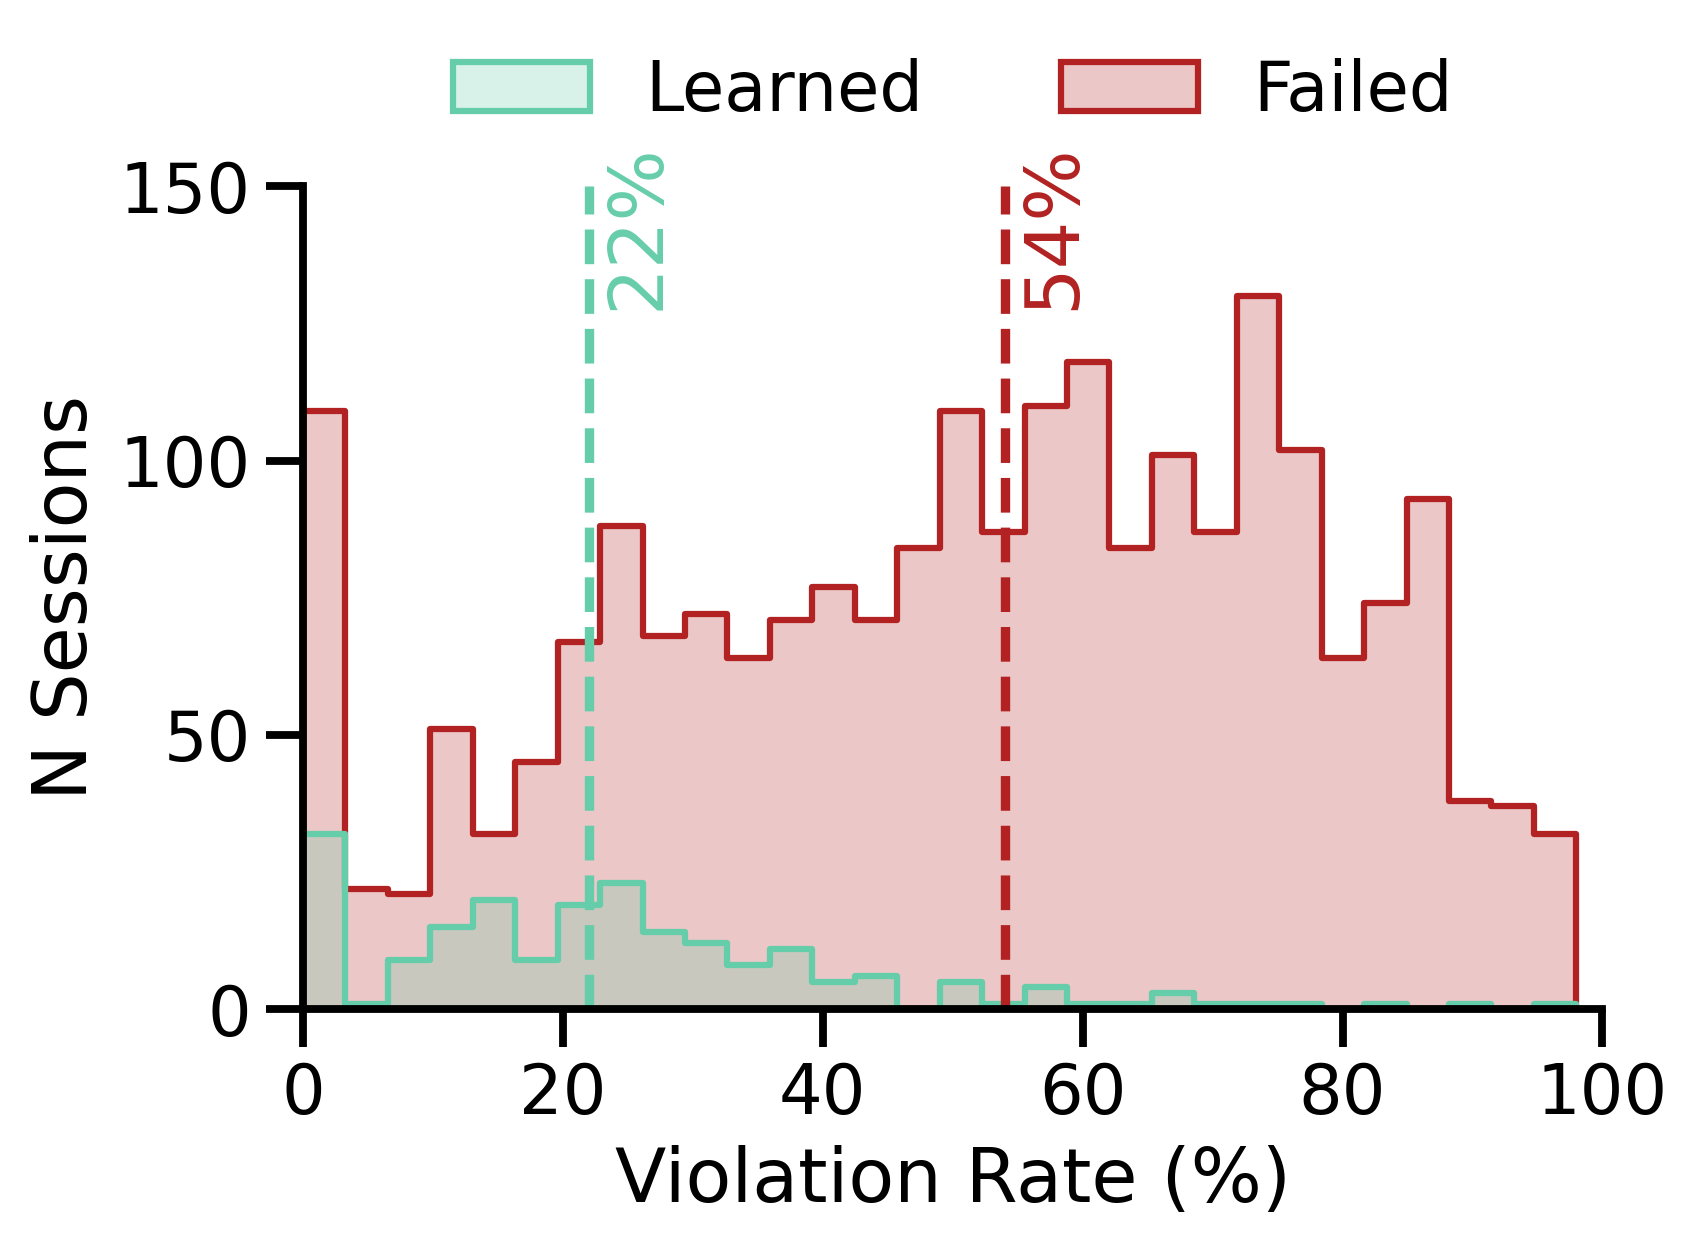

In [90]:

plot_violations_hist(
    df=plot_df.query("stage == 2"),
    hue="training_label",
    palette=LEARNED_PALETTE,
    hue_order=LEARNED_ORDER,
    ylim=(0, 150),
    label_ylim_pct=0.85,
)

<Axes: xlabel='Violation Rate (%)', ylabel='N Sessions'>

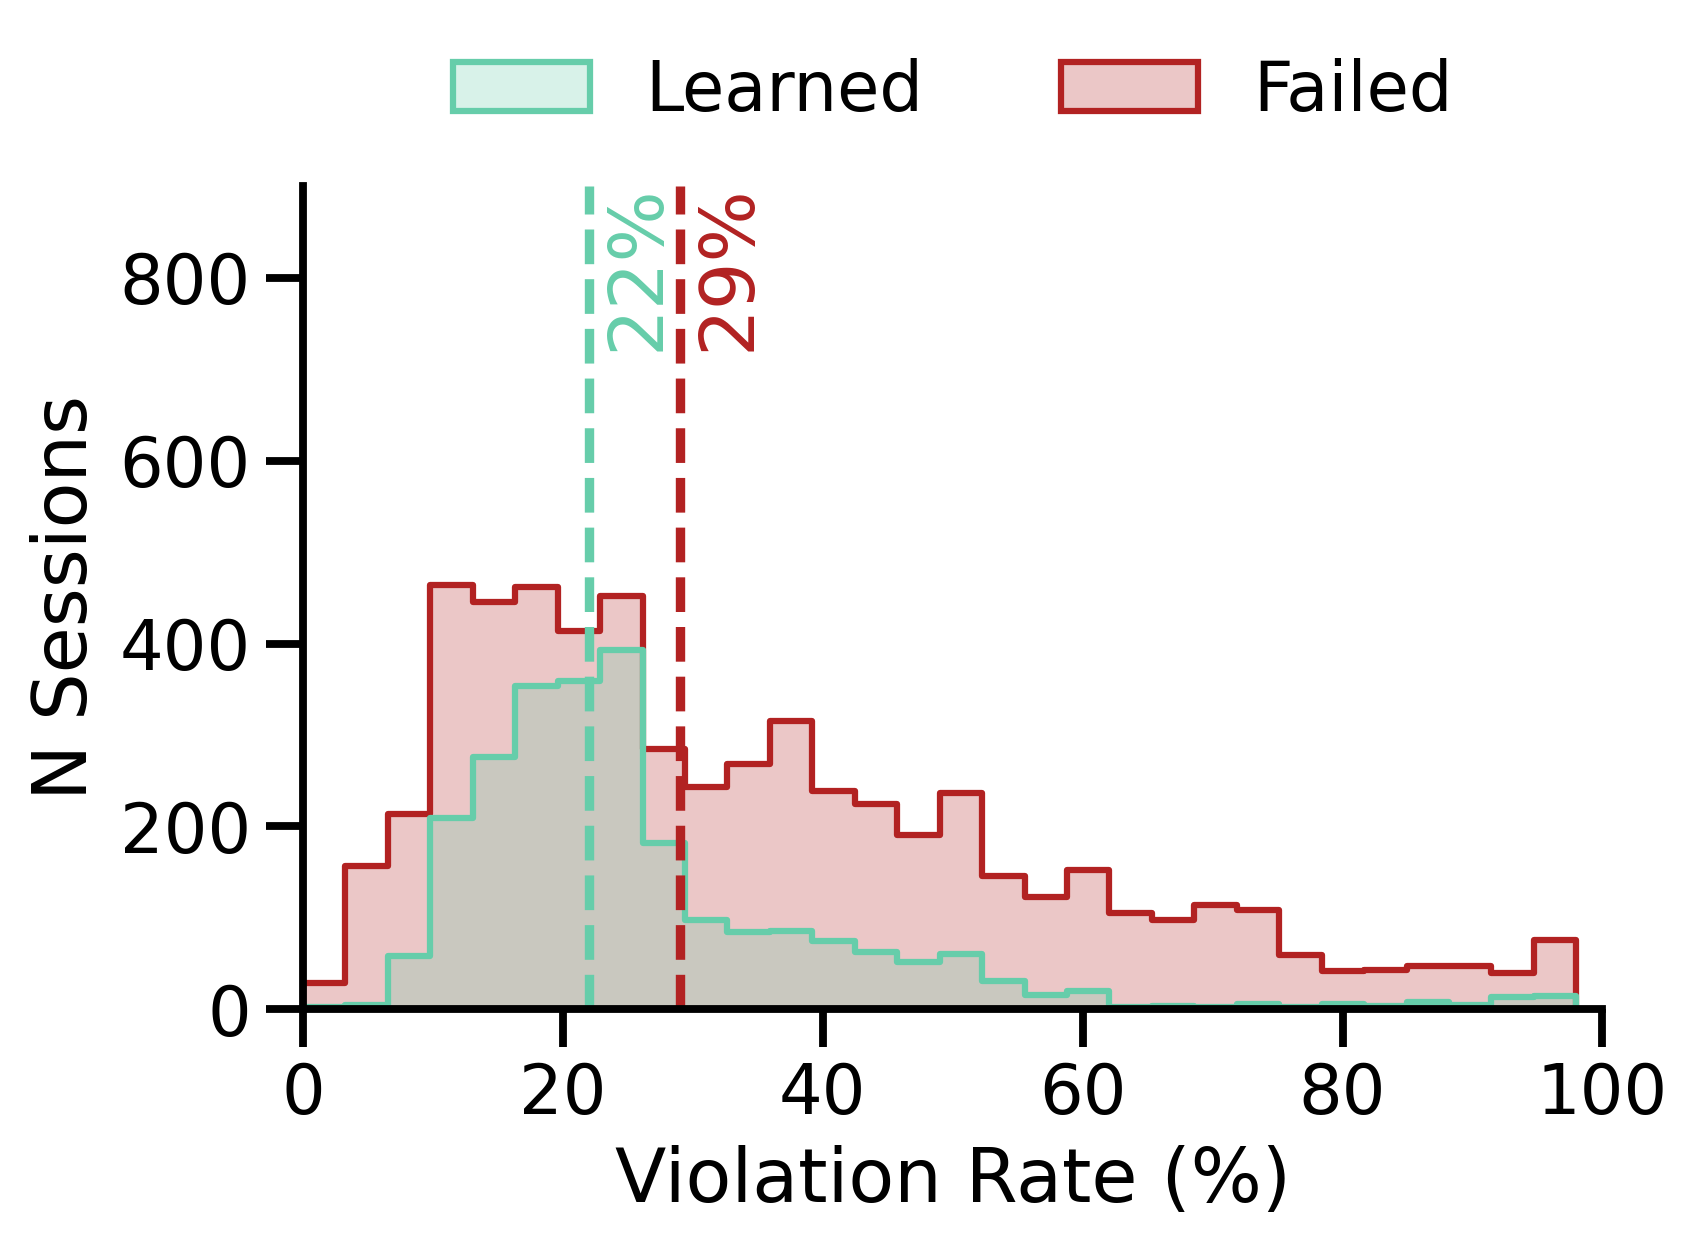

In [91]:

plot_violations_hist(
    df=plot_df.query("stage > 2"),
    hue="training_label",
    palette=LEARNED_PALETTE,
    hue_order=LEARNED_ORDER,
    ylim=(0, 900),
    label_ylim_pct=0.80,
    title=""
)


<Axes: xlabel='Violation Rate (%)', ylabel='N Sessions'>

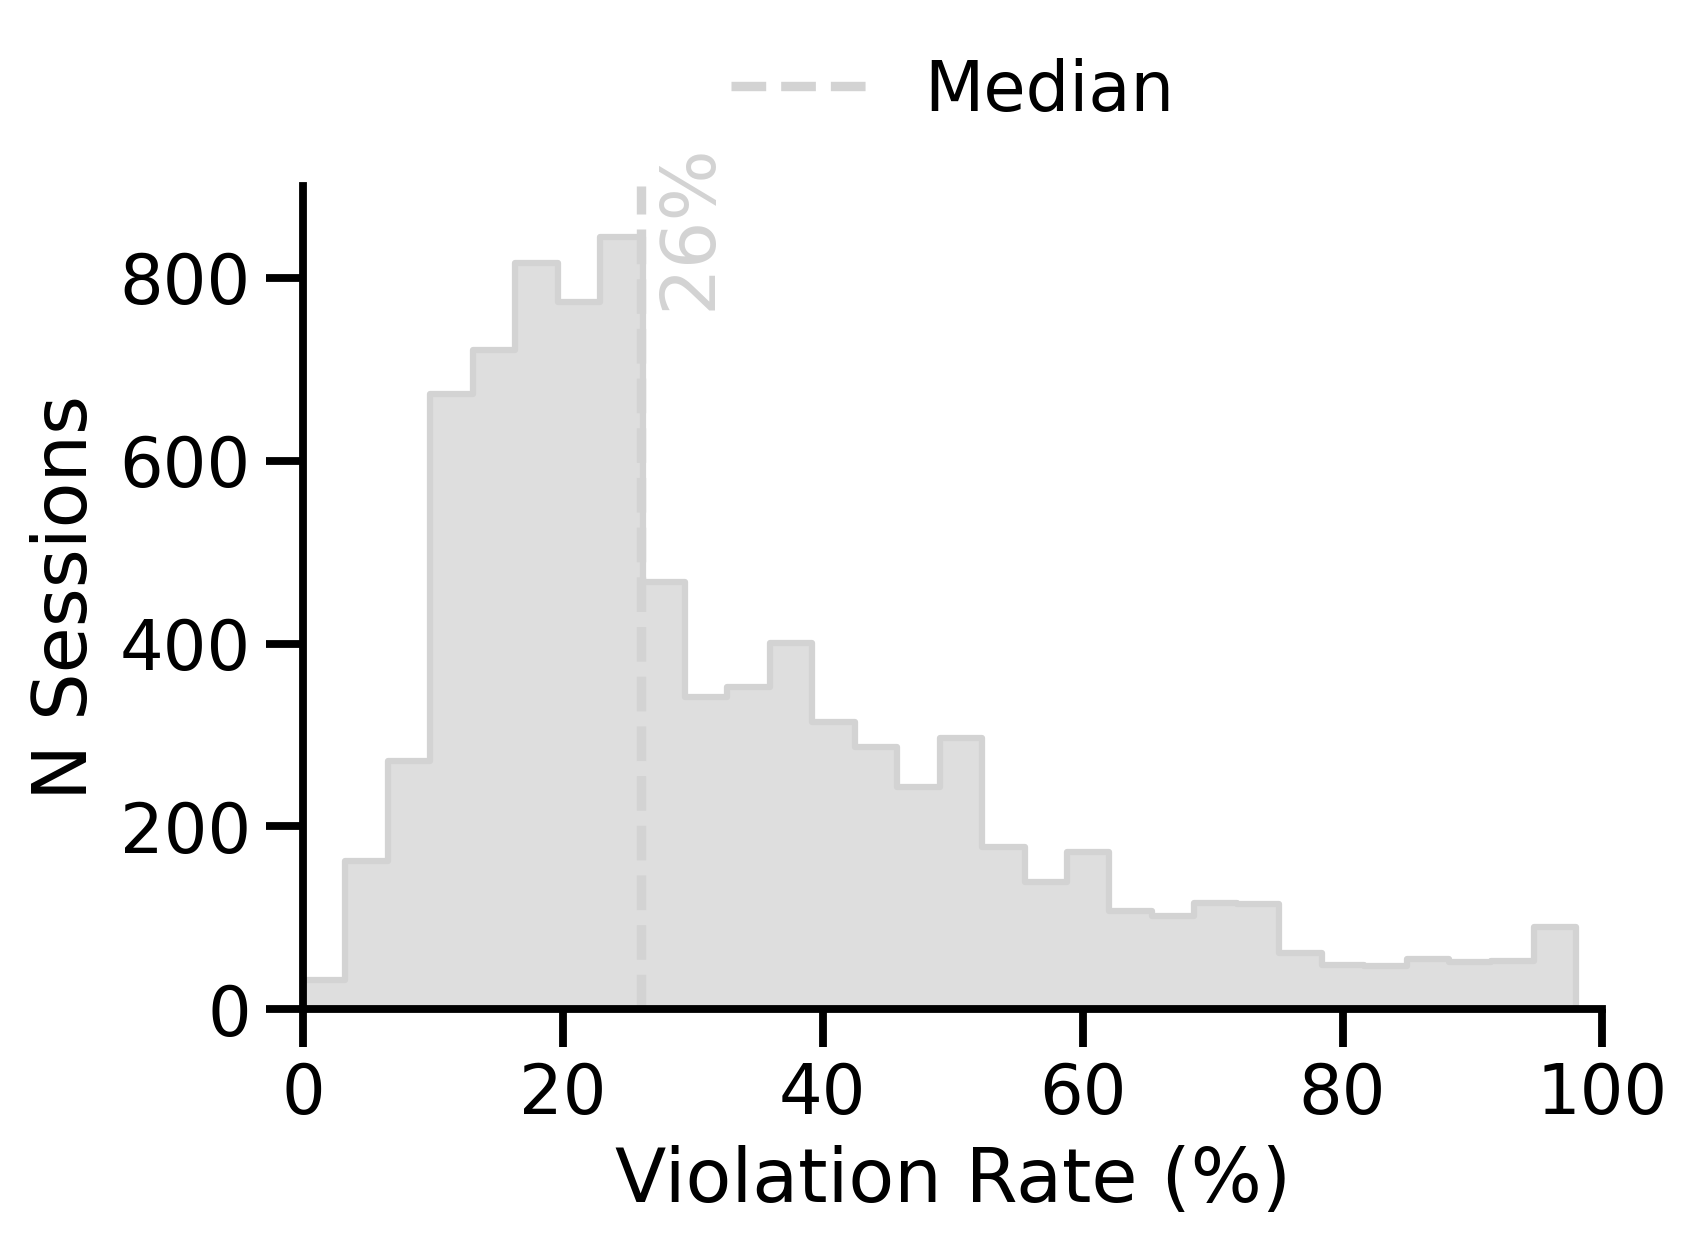

In [102]:

plot_violations_hist(
    df=plot_df.query("stage > 2"),
    hue=None,
    palette=None,            # ignored when hue is None
    ylim=(0, 900),
    label_ylim_pct=0.85,     # ignored when hue is None
    hue_order=None,
    color=NO_HUE_COLOR
)

## 2.3 Fixation Time


In [20]:
stage2_days = (
    pwm_df.query("sound_rule_exposed and stage == 2")
    .groupby(["animal_id","training_label"])["date"]
    .nunique()
    .reset_index(name="n_days_stage_2")
)

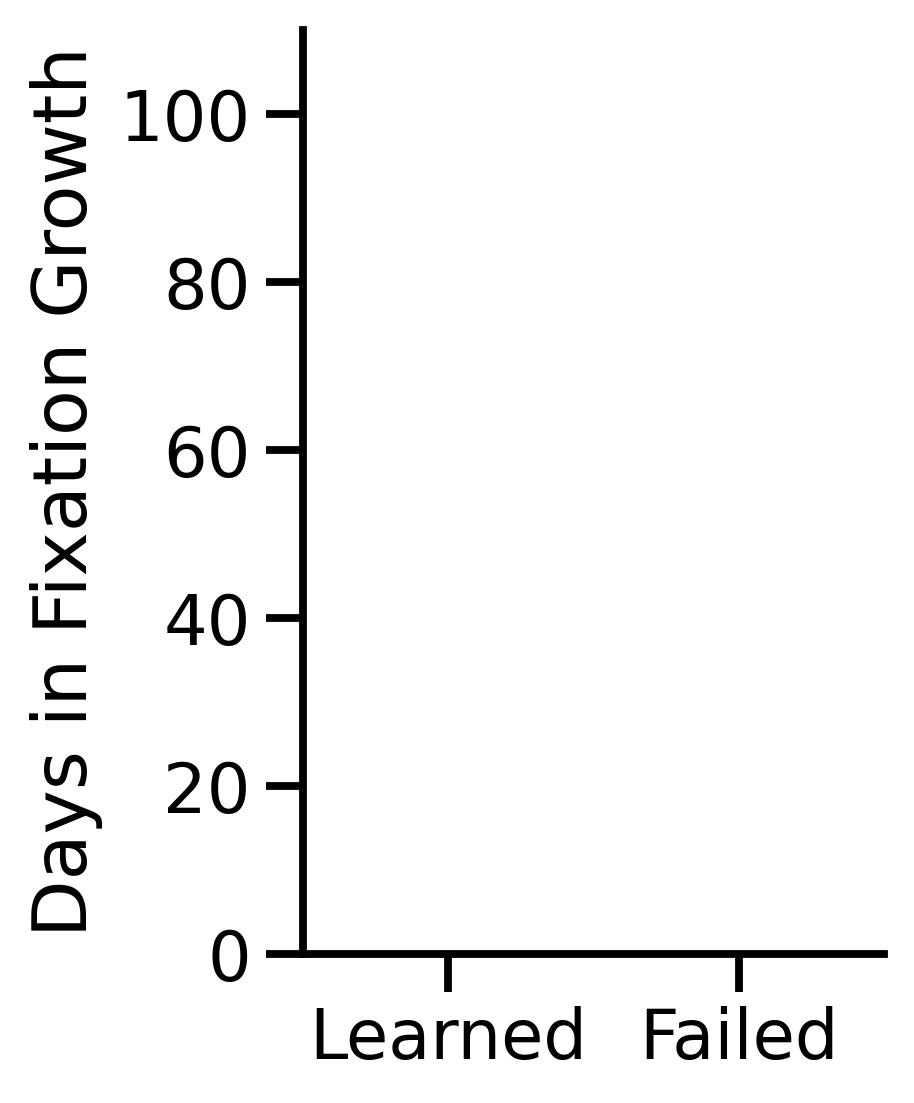

In [25]:
fig, ax = plt.subplots(figsize=(2.5,4), dpi=300)
sns.pointplot(
    data=stage2_days,
    x="training_label",
    y="n_days_stage_2",
    hue="training_label",
    palette=["white", "white"],
    hue_order=LEARNED_ORDER,
    order=LEARNED_ORDER,
    ax=ax,
    errorbar="se"
)

ax.set(
    title="",
    ylabel="Days in Fixation Growth",
    xlabel="",
    ylim=(0, 110)

)
sns.despine(ax=ax)

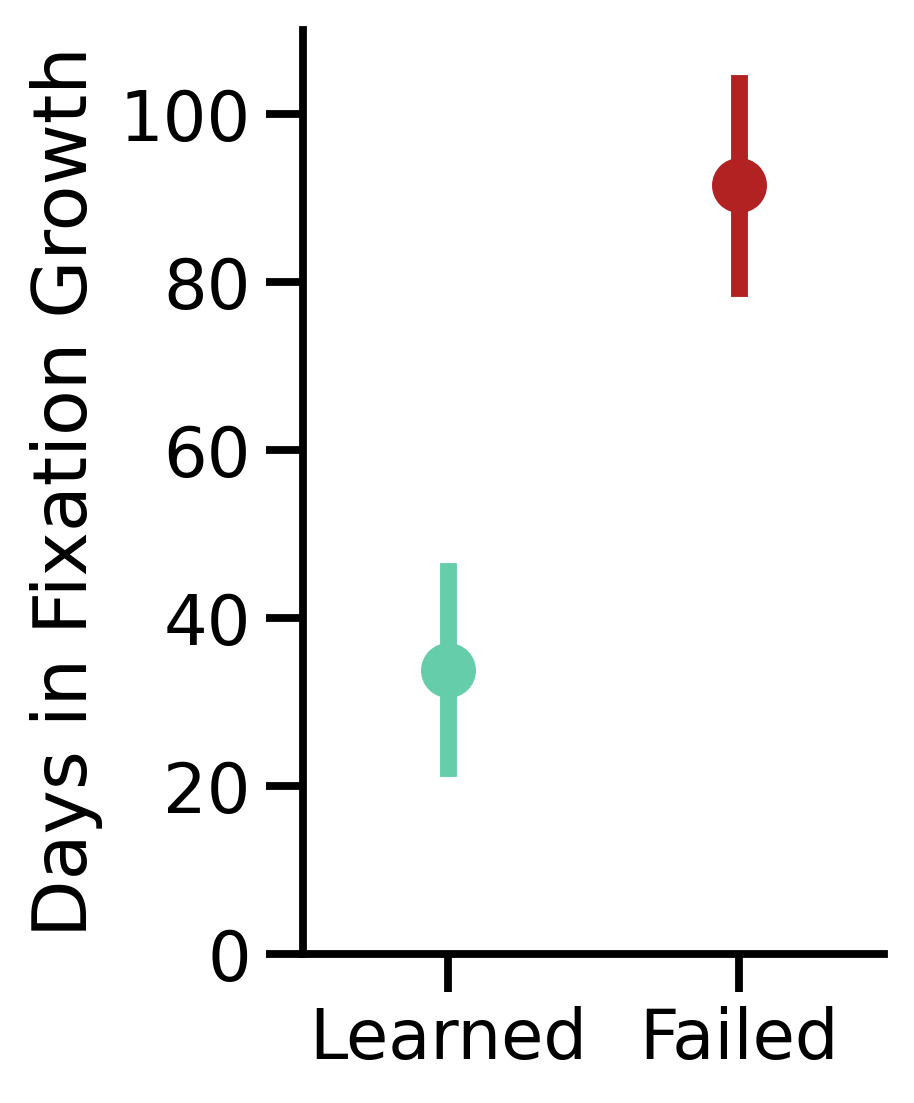

In [24]:
fig, ax = plt.subplots(figsize=(2.5,4), dpi=300)
sns.pointplot(
    data=stage2_days,
    x="training_label",
    y="n_days_stage_2",
    hue="training_label",
    palette=LEARNED_PALETTE,
    hue_order=LEARNED_ORDER,
    order=LEARNED_ORDER,
    ax=ax,
    errorbar="se"
)

ax.set(
    title="",
    ylabel="Days in Fixation Growth",
    xlabel="",
    ylim=(0, 110)

)
sns.despine(ax=ax)